
# **Recurrence Type prediction**

local / distant prediction

**Import Required Libraries**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score
import xgboost as xgb
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from keras.optimizers import Adam
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import roc_curve, auc
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
import lightgbm as lgb
import joblib

c:\Users\nadat\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


# **1.1. Reading General merged data**

In [2]:
data= pd.read_csv('Final_general_merged.csv')
data.head()

C:\Users\nadat\AppData\Local\Temp\ipykernel_12644\276089922.py:1: DtypeWarning: Columns (0,11,15) have mixed types. Specify dtype option on import or set low_memory=False.
  data= pd.read_csv('Final_general_merged.csv')


,Menopausal Status,Tumor Size,Lymph Node Status,Tumor Grade,Mol Subtype,Histological Type,ER,PR,HER2,Chemotherapy,...,Overall Survival Status (Month),Recurrence Free Status (Month),Recurrence Free Status,Age,Surgery,Recurrence_Type,Bone_metastasis,Brain_metastasis,Lung_metastasis,Liver_metastasis
0,Post,T2,N3,III,Luminal A,Infiltrating duct carcinoma,Positive,Negative,Negative,No,...,140.500000,138.65,Not Recurrence,75-79 years,NaN,NaN,NaN,NaN,NaN,NaN
1,Pre,T1,N0,III,Luminal A,Infiltrating duct carcinoma,Positive,Positive,Negative,No,...,84.633333,83.52,Not Recurrence,40-44 years,NaN,NaN,NaN,NaN,NaN,NaN
2,Pre,T1,N1,II,Luminal B,Infiltrating duct carcinoma,Positive,Positive,Negative,Yes,...,163.700000,151.28,Recurrence,45-49 years,NaN,NaN,NaN,NaN,NaN,NaN
3,Pre,T2,N1,II,Luminal B,Infiltrating duct and lobular carcinoma,Positive,Positive,Negative,Yes,...,164.933333,162.76,Not Recurrence,45-49 years,NaN,NaN,NaN,NaN,NaN,NaN
4,Post,T2,N2,III,Luminal B,Infiltrating duct and lobular carcinoma,Positive,Positive,Negative,Yes,...,41.366667,18.55,Recurrence,75-79 years,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
data.columns

Index(['Menopausal Status', 'Tumor Size', 'Lymph Node Status', 'Tumor Grade',
       'Mol Subtype', 'Histological Type', 'ER', 'PR', 'HER2', 'Chemotherapy',
       'Radiotherapy', 'Type of Surgery', 'Tumor Location',
       'Overall Survival Status (Month)', 'Recurrence Free Status (Month)',
       'Recurrence Free Status', 'Age', 'Surgery', 'Recurrence_Type',
       'Bone_metastasis', 'Brain_metastasis', 'Lung_metastasis',
       'Liver_metastasis'],
      dtype='object')

Remove histological types that are not found in baheya

In [4]:
data = data[ (data['Histological Type'] != 'Metaplastic carcinoma') &  (data['Histological Type'] != 'Cribriform carcinoma') & (data['Histological Type'] != 'Mucinous adenocarcinoma')]

# **1.2. Data selection from general data**

In [5]:
selected_data = data[['Tumor Size','Recurrence_Type', 'Lymph Node Status', 'Tumor Grade', 'Mol Subtype', 'Histological Type', 'ER', 'PR', 'HER2', 'Tumor Location']]

# **1.3. Data Balancing**


In [6]:
selected_data['Recurrence_Type'].value_counts()

Recurrence_Type
Local      170745
Distant     11024
Normal       1086
Name: count, dtype: int64

In [7]:
selected_data = selected_data[ (selected_data['Recurrence_Type'] != 'No') & (selected_data['Recurrence_Type'] != 'Normal') ]

In [8]:
selected_data['Recurrence_Type'].value_counts()

Recurrence_Type
Local      170745
Distant     11024
Name: count, dtype: int64

In [9]:
# Function to sample each group
def sample_group(group, n):
    if len(group) < n:
        return group
    return group.sample(n)

balanced_data = selected_data.groupby('Recurrence_Type', group_keys=False).apply(lambda x: sample_group(x, 11181)).reset_index(drop=True)

print(balanced_data['Recurrence_Type'].value_counts())


Recurrence_Type
Local      11181
Distant    11024
Name: count, dtype: int64


C:\Users\nadat\AppData\Local\Temp\ipykernel_12644\2558046598.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  balanced_data = selected_data.groupby('Recurrence_Type', group_keys=False).apply(lambda x: sample_group(x, 11181)).reset_index(drop=True)


In [10]:
balanced_data.isna().sum()

Tumor Size           0
Recurrence_Type      0
Lymph Node Status    0
Tumor Grade          0
Mol Subtype          0
Histological Type    0
ER                   0
PR                   0
HER2                 0
Tumor Location       0
dtype: int64



---







---



## **2. Feature Engineering**




## **2.1. Prepare features and target variable**

In [11]:
X = balanced_data.drop(columns=['Recurrence_Type'],axis=1)
y = balanced_data['Recurrence_Type'] 

In [12]:
X

,Tumor Size,Lymph Node Status,Tumor Grade,Mol Subtype,Histological Type,ER,PR,HER2,Tumor Location
0,T3,N2,III,Triple Negative,Lobular carcinoma,Negative,Negative,Negative,Left
1,T2,N2,III,Triple Negative,Infiltrating duct carcinoma,Negative,Negative,Negative,Right
2,T4,N1,III,Triple Negative,Infiltrating duct carcinoma,Negative,Negative,Negative,Left
3,T4,N3,II,Triple Negative,Infiltrating duct carcinoma,Negative,Negative,Negative,Right
4,T1,N1,III,Luminal B,Infiltrating duct carcinoma,Positive,Negative,Positive,Right
...,...,...,...,...,...,...,...,...,...
22200,T1,N0,II,HER2 enriched,Infiltrating duct carcinoma,Negative,Negative,Positive,Right
22201,T1,N0,II,Luminal A,Infiltrating duct carcinoma,Positive,Positive,Negative,Left
22202,T3,N0,III,Triple Negative,Infiltrating duct carcinoma,Negative,Negative,Negative,Right
22203,T1,N0,II,Luminal A,Infiltrating duct carcinoma,Positive,Positive,Negative,Left


## **2.2 Encoding**

**Features**

In [13]:
X = pd.get_dummies(X, columns=['Tumor Size'	,'Lymph Node Status','Tumor Grade'	,'Mol Subtype'	,'Histological Type',	'ER'	,'PR'	,'HER2',	'Tumor Location'])

**Target**

In [14]:
label_encoder = LabelEncoder()

y = label_encoder.fit_transform(y)

In [15]:
for i, class_name in enumerate(label_encoder.classes_):
    print(f"{i}: {class_name}")

0: Distant
1: Local


**Feature Importance**

In [16]:
mi_scores = mutual_info_classif(X, y)

mi_scores_df = pd.DataFrame({'Feature': X.columns, 'Mutual Information Score': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information Score', ascending=False)

print(mi_scores_df)


                                              Feature  \
5                                Lymph Node Status_N0   
6                                Lymph Node Status_N1   
1                                       Tumor Size_T1   
4                                       Tumor Size_T4   
8                                Lymph Node Status_N3   
7                                Lymph Node Status_N2   
3                                       Tumor Size_T3   
9                                       Tumor Grade_I   
11                                    Tumor Grade_III   
24                                      HER2_Negative   
21                                        ER_Positive   
13                              Mol Subtype_Luminal A   
12                          Mol Subtype_HER2 enriched   
2                                       Tumor Size_T2   
22                                        PR_Negative   
15                        Mol Subtype_Triple Negative   
25                             

## **2.3 Train-Test Split**

In [17]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify = y)

## **3. Model Training & Evaluation**




### **XGBoost Model**

In [18]:
XG = xgb.XGBClassifier()

param_grid = {
    'n_estimators': [100, 200, 300, 500, 700, 1000],  
    'max_depth': [1, 3, 5, 7, 10],
    'learning_rate': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid_search = GridSearchCV(estimator=XG, param_grid=param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

print("Best Hyperparameters:", grid_result.best_params_)

best_XG = grid_result.best_estimator_

y_pred = best_XG.predict(X_test)

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 100}


In [19]:
y_train_pred = best_XG.predict(X_train)

In [20]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

Training Set Accuracy: 0.9079328314997105
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      7717
           1       0.85      0.99      0.92      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [21]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.9013809666766737
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      3307
           1       0.84      0.99      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



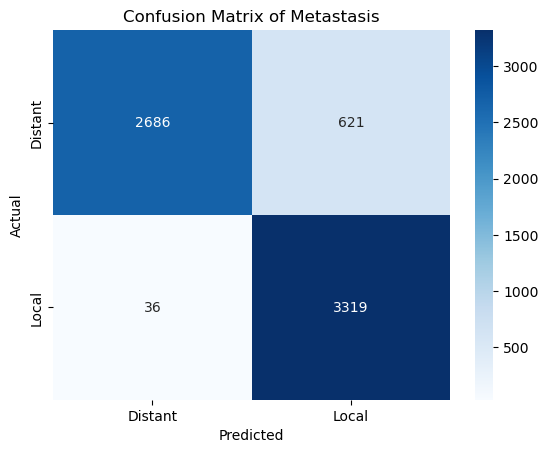

In [22]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

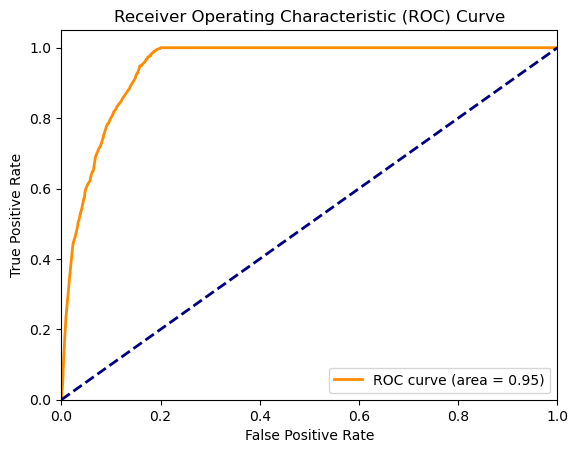

In [23]:
# Make predictions and compute ROC curve
y_pred_prob = best_XG.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [24]:
joblib.dump(best_XG, 'model_locdis_XG.pkl')

['model_locdis_XG.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________






### **Random Forest Model**

In [25]:
# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],           
    'max_depth': [None, 10, 20, 30, 40, 50],          
}

RF = RandomForestClassifier(random_state=42)

grid_search = GridSearchCV(estimator=RF, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_rf = grid_search.best_estimator_

# Print the best parameters
print("Best parameters found: ", best_params)

# Make predictions
y_pred = best_rf.predict(X_test)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best parameters found:  {'max_depth': 10, 'n_estimators': 400}


In [26]:
y_train_pred = best_rf.predict(X_train)

In [27]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

Training Set Accuracy: 0.90921958437882
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      7717
           1       0.85      0.99      0.92      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [28]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.9010807565295706
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      3307
           1       0.84      0.99      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



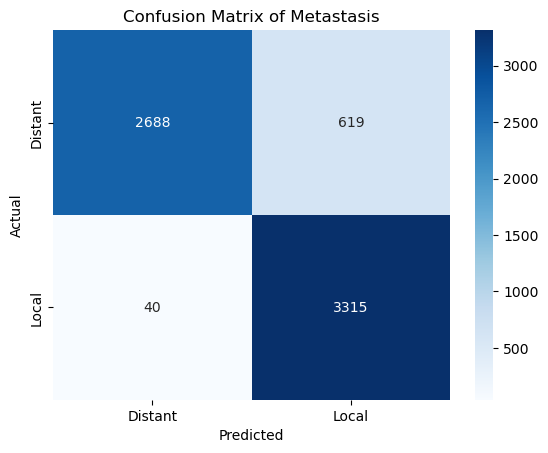

In [29]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

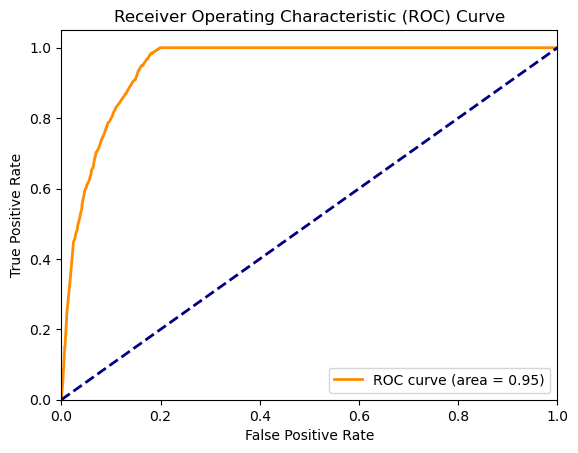

In [30]:
# Make predictions and compute ROC curve
y_pred_prob = best_rf.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [31]:
joblib.dump(best_rf, 'model_locdis_rf.pkl')

['model_locdis_rf.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________






### **SVM Model**

In [32]:
SVM = SVC(kernel='rbf', C=1000, gamma=0.1)

SVM.fit(X_train, y_train)

y_pred = SVM.predict(X_test)

In [33]:
y_train_pred = SVM.predict(X_train)

In [34]:
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

Training Set Accuracy: 0.9097986231744194
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.83      0.90      7717
           1       0.85      0.99      0.92      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [35]:
test_accuracy = accuracy_score(y_test, y_pred)
test_report = classification_report(y_test, y_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)

Testing Set Accuracy: 0.8989792854998498
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      3307
           1       0.84      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



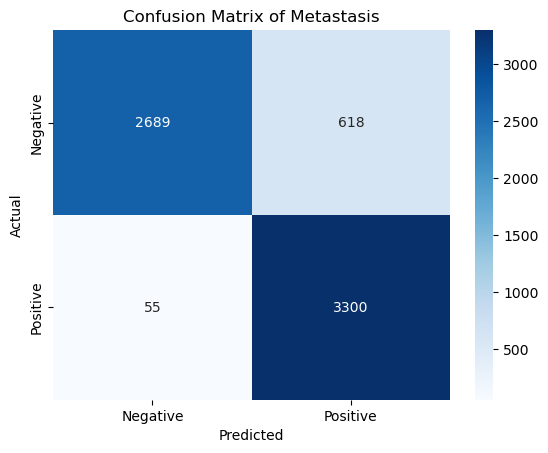

In [36]:
conf_matrix = confusion_matrix(y_test, y_pred)

sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

In [37]:
joblib.dump(SVM, 'model_locdis_SV.pkl')

['model_locdis_SV.pkl']


______________________________________________________________________________________________________________________________________________________________________________________________________________________________________






### **NN Model**

In [38]:
# Define the neural network model
model_Mets_NN = Sequential([
    Dense(128, activation='relu', input_dim=X_train.shape[1]),  # To capture non-linear complex relations
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')  # Using sigmoid for binary classification
])

# Compile the model
model_Mets_NN.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.002), metrics=['accuracy'])

# Train the model
history = model_Mets_NN.fit(X_train, y_train, epochs=20, batch_size=64, verbose=0)

# Make predictions on the training set using the neural network
y_train_pred = model_Mets_NN.predict(X_train)
y_train_pred = (y_train_pred > 0.5).astype(int)  # Convert probabilities to binary predictions

# Evaluate the model on the training set
train_accuracy = accuracy_score(y_train, y_train_pred)
train_report = classification_report(y_train, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

c:\Users\nadat\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:86: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


486/486 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Training Set Accuracy: 0.9082545197194879
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      7717
           1       0.85      0.99      0.92      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543



In [39]:
y_test_pred = model_Mets_NN.predict(X_test)
y_test_pred = (y_test_pred > 0.5).astype(int)  # Convert probabilities to binary predictions
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)


209/209 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
Testing Set Accuracy: 0.8995797057940559
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.81      0.89      3307
           1       0.84      0.98      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



**LGB**

In [40]:
param_grid_lgb = {
    'n_estimators': [100, 200, 300, 500, 700],
    'max_depth': [10, 20, 30, 50], 
    'learning_rate': [0.01, 0.05, 0.1]
}


model = lgb.LGBMClassifier()
    
grid_search = GridSearchCV(estimator=model, param_grid=param_grid_lgb, cv=3)
grid_result = grid_search.fit(X_train, y_train)
    
best_lgb = grid_result.best_estimator_
    
best_lgb.fit(X_train, y_train)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 5217, number of negative: 5145
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001184 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 10362, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503474 -> initscore=0.013897
[LightGBM] [Info] Start training from score 0.013897
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_lea

LGBMClassifier(learning_rate=0.01, max_depth=10, n_estimators=300)

In [41]:
# Make predictions on the test set
y_pred = best_lgb.predict(X_train)

# Evaluate the model
Train_accuracy_lgbm = accuracy_score(y_train, y_pred)
train_report = classification_report(y_train, y_pred)
print("Accuracy:", Train_accuracy_lgbm)
print("Training Set Classification Report:\n", train_report)

y_test_pred = best_lgb.predict(X_test)
test_accuracy = accuracy_score(y_test, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)


[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Accuracy: 0.9070964421282892
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.82      0.90      7717
           1       0.85      0.99      0.91      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Testing Set Accuracy: 0.9012308616031222
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.81      0.89      3307
           1       0.84      0.99      0.91      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      666

In [42]:
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(best_lgb, X_train, y_train, cv=10, scoring='accuracy')

print("Cross-Validation Scores:", cv_scores)
print("Mean Accuracy:", cv_scores.mean())

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Number of positive: 7043, number of negative: 6945
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001140 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 52
[LightGBM] [Info] Number of data points in the train set: 13988, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503503 -> initscore=0.014012
[LightGBM] [Info] Start training from score 0.014012
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_lea

In [43]:
joblib.dump(best_lgb, 'model_locdis_lgb.pkl')

['model_locdis_lgb.pkl']

**KNN**

In [71]:
# Ensure the arrays are contiguous
X_train_contiguous = np.ascontiguousarray(X_train)
y_train_contiguous = np.ascontiguousarray(y_train)

# Define the parameter grid for KNN
param_grid = {
    'n_neighbors': [3, 5, 7, 9, 11, 13, 15],
    'weights': ['uniform', 'distance'],
    'metric': ['euclidean', 'manhattan', 'minkowski']
}

# Initialize the KNN classifier
knn = KNeighborsClassifier()

# Initialize GridSearchCV with KNN and the parameter grid
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, cv=5, scoring='accuracy', verbose=1)

# Fit GridSearchCV on the training data
grid_search.fit(X_train_contiguous, y_train_contiguous)

# Get the best parameters and the best model
best_params = grid_search.best_params_
best_knn = grid_search.best_estimator_

print("Best Parameters:", best_params)

# Train the best model on the training data
best_knn.fit(X_train_contiguous, y_train_contiguous)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
Best Parameters: {'metric': 'manhattan', 'n_neighbors': 15, 'weights': 'distance'}


KNeighborsClassifier(metric='manhattan', n_neighbors=15, weights='distance')

In [74]:
# Make predictions on the training set
y_train_pred = best_knn.predict(X_train_contiguous)
train_accuracy = accuracy_score(y_train_contiguous, y_train_pred)
train_report = classification_report(y_train_contiguous, y_train_pred)

print("Training Set Accuracy:", train_accuracy)
print("Training Set Classification Report:\n", train_report)

# Ensure the arrays are contiguous
X_test_contiguous = np.ascontiguousarray(X_test)
y_test_contiguous = np.ascontiguousarray(y_test)

y_test_pred = best_knn.predict(X_test_contiguous)
test_accuracy = accuracy_score(y_test_contiguous, y_test_pred)
test_report = classification_report(y_test, y_test_pred)

print("Testing Set Accuracy:", test_accuracy)
print("Testing Set Classification Report:\n", test_report)


Training Set Accuracy: 0.9088335585150872
Training Set Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.84      0.90      7717
           1       0.86      0.98      0.92      7826

    accuracy                           0.91     15543
   macro avg       0.92      0.91      0.91     15543
weighted avg       0.92      0.91      0.91     15543

Testing Set Accuracy: 0.8961272891023716
Testing Set Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.82      0.89      3307
           1       0.85      0.97      0.90      3355

    accuracy                           0.90      6662
   macro avg       0.91      0.90      0.90      6662
weighted avg       0.91      0.90      0.90      6662



In [75]:
joblib.dump(best_knn, 'model_locdis_KNN.pkl')

['model_locdis_KNN.pkl']

**Combined Train Test ROC**

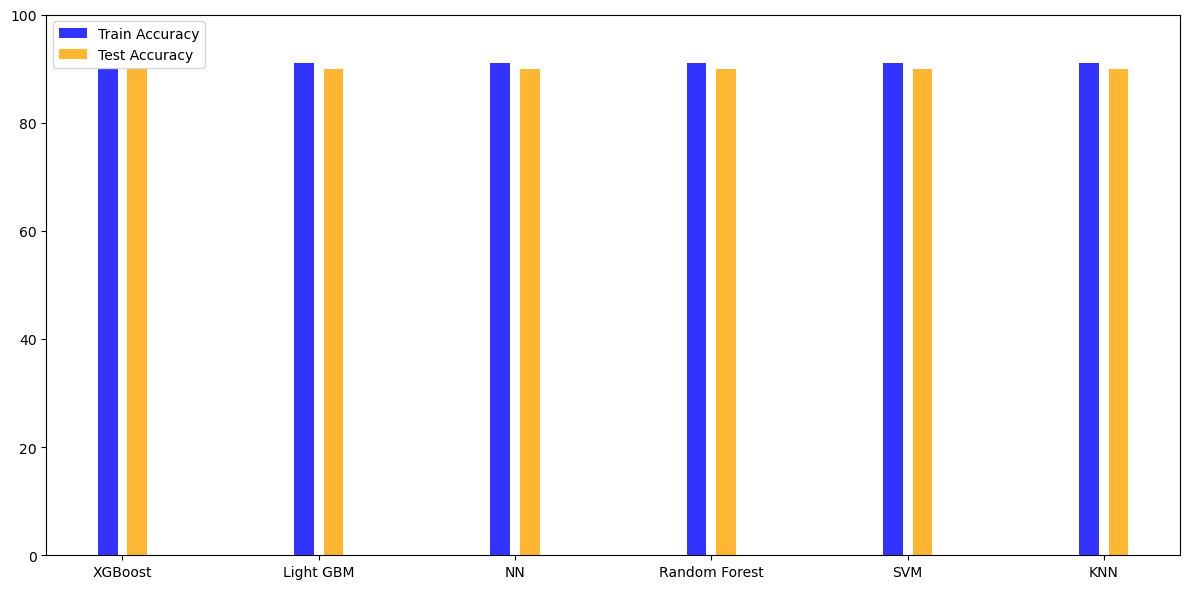

In [76]:
models = ['XGBoost', 'Light GBM', 'NN', 'Random Forest', 'SVM', 'KNN']
metrics = ['Train Accuracy', 'Test Accuracy']
values = np.array([
    [90, 91, 91, 91, 91, 91],
    [90, 90, 90, 90, 90, 90]
])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1  # thinner bars
opacity = 0.8
space = 0.05  # space between the bars
colors = ['blue', 'orange'] 

for i, metric in enumerate(metrics):
    rects = ax.bar(np.arange(len(models)) + (i * (bar_width + space)), values[i], bar_width,
                   alpha=opacity, color=colors[i], label=metric)

ax.set_ylim(0, 100)  # Set y-axis range from 0 to 100

ax.set_xticks(np.arange(len(models)) + ((len(metrics) - 1) * (bar_width + space)) / 2)  # Center x-ticks
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.savefig('Train_Test_LocDist.svg', format='svg')
plt.show()


# **Baheya validation**

In [77]:
Baheya_data = pd.read_csv('Final_Baheya_Merged.csv')
Baheya_data.head()

,Menopausal Status,Tumor Size,Lymph Node Status,Tumor Location,Histological Type,Tumor Grade,ER,PR,HER2,Mol Subtype,Recurrence Free Status (Month),Overall Survival Status (Month),Recurrence_Type,Recurrence Free Status
0,Post,T3,N1,Right,Infiltrating duct carcinoma,II,Positive,Positive,Negative,Luminal A,27.0,32.0,Normal,Not Recurrence
1,Post,T2,N1,Left,Infiltrating duct carcinoma,II,Negative,Negative,Positive,HER2 enriched,99.0,99.0,Normal,Not Recurrence
2,Post,T2,N2,Left,Infiltrating duct carcinoma,II,Positive,Positive,Negative,Luminal A,97.0,97.0,Normal,Not Recurrence
3,Pre,T4,N2,Right,Infiltrating duct carcinoma,II,Positive,Positive,Negative,Luminal A,95.0,96.0,Normal,Not Recurrence
4,Post,T4,N2,Right,Infiltrating duct carcinoma,II,Positive,Positive,Negative,Luminal A,83.0,88.0,Normal,Not Recurrence


In [78]:
Baheya_data = Baheya_data.drop(columns=['Menopausal Status','Recurrence Free Status (Month)','Overall Survival Status (Month)'	,'Recurrence Free Status','Menopausal Status'],axis=1)


In [79]:
Baheya_data['Recurrence_Type'].value_counts()

Recurrence_Type
Distant    267
Normal     152
Local       49
Name: count, dtype: int64

In [80]:
Baheya_data = Baheya_data[Baheya_data['Recurrence_Type'] != 'Normal']

In [81]:
X_val_Mets = Baheya_data.drop(columns=['Recurrence_Type'],axis=1)
y_val_Mets = Baheya_data['Recurrence_Type']

In [82]:
X_val_Mets = pd.get_dummies(X_val_Mets, columns=['Tumor Size','Lymph Node Status','Tumor Grade'	,'Mol Subtype'	,'Histological Type',	'ER'	,'PR'	,'HER2',	'Tumor Location'])

In [83]:
y_val_Mets = label_encoder.transform(y_val_Mets)

In [84]:
X_val_Mets.insert(0,'Tumor Size_T0', 0)

**XGBoost**

In [85]:
y_pred_val_Mets = best_XG.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_Mets)
val_report = classification_report(y_val_Mets, y_pred_val_Mets)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)


Val Accuracy: 0.7848101265822784
Val Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       267
           1       0.32      0.35      0.33        49

    accuracy                           0.78       316
   macro avg       0.60      0.61      0.60       316
weighted avg       0.79      0.78      0.79       316



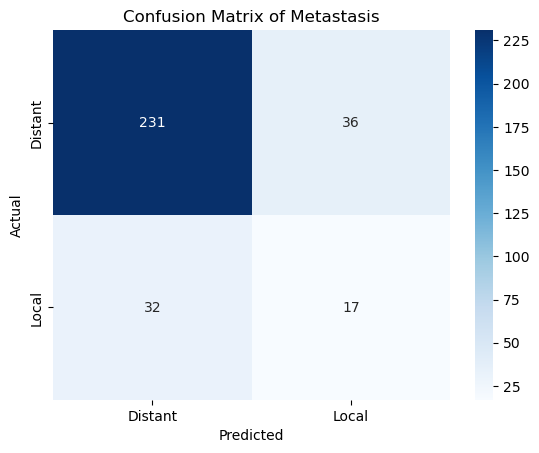

In [86]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_Mets)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**Random Forest**

In [87]:
y_pred_val_Mets = best_rf.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_Mets)
val_report = classification_report(y_val_Mets, y_pred_val_Mets)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)


Val Accuracy: 0.7816455696202531
Val Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       267
           1       0.31      0.35      0.33        49

    accuracy                           0.78       316
   macro avg       0.60      0.60      0.60       316
weighted avg       0.79      0.78      0.79       316



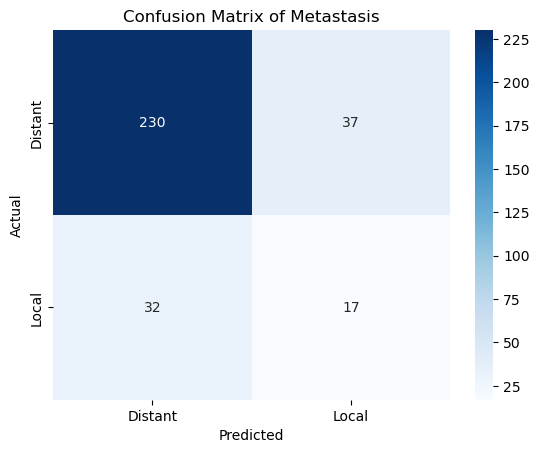

In [88]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_Mets)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**SVM**

In [89]:
y_pred_val_Mets = SVM.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_Mets)
val_report = classification_report(y_val_Mets, y_pred_val_Mets)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)


Val Accuracy: 0.7816455696202531
Val Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87       267
           1       0.31      0.35      0.33        49

    accuracy                           0.78       316
   macro avg       0.60      0.60      0.60       316
weighted avg       0.79      0.78      0.79       316



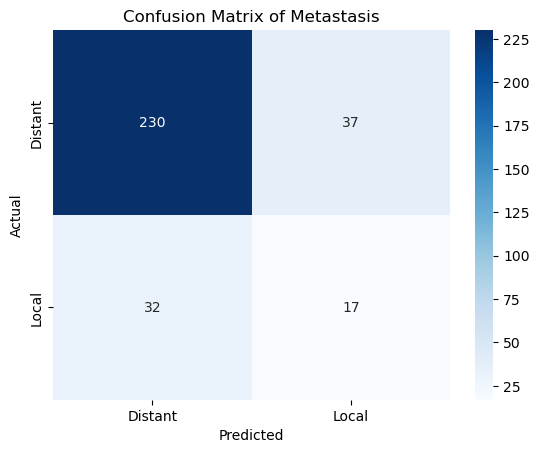

In [90]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_Mets)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**NN**

In [91]:
import numpy as np

y_val = np.array(y_val_Mets)  # Convert y_val to a NumPy array if it's not already

# Ensure X_val_scaled contains only float values
X_val_Mets = X_val_Mets.astype(np.float32)

# Predict on the validation set
y_pred_NN = model_Mets_NN.predict(X_val_Mets)

# Evaluate the model on the validation set
val_loss, val_accuracy = model_Mets_NN.evaluate(X_val_Mets, y_val_Mets)

# Generate classification report
val_report = classification_report(y_val, (y_pred_NN > 0.5).astype(int))

# Print validation metrics
print(f"Validation Loss: {val_loss:.4f}")
print("Validation Set Accuracy:", val_accuracy)
print("Validation Set Classification Report:\n", val_report)


10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.8603 - loss: 0.7812 
Validation Loss: 2.9253
Validation Set Accuracy: 0.7816455960273743
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       267
           1       0.31      0.35      0.33        49

    accuracy                           0.78       316
   macro avg       0.60      0.60      0.60       316
weighted avg       0.79      0.78      0.79       316



10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


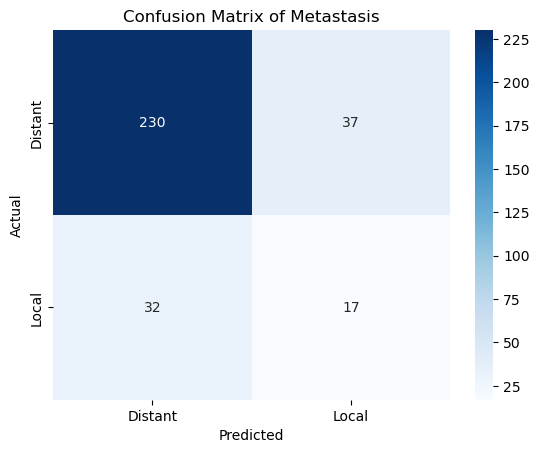

In [92]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
y_val_pred = (model_Mets_NN.predict(X_val_Mets) > 0.5).astype(int)

conf_matrix = confusion_matrix(y_val_Mets, y_val_pred)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**LGB**

In [93]:
y_pred_val_Mets = best_lgb.predict(X_val_Mets)
val_acc = accuracy_score(y_val_Mets, y_pred_val_Mets)
val_report = classification_report(y_val_Mets, y_pred_val_Mets)
print("\nVal Accuracy:", val_acc)
print("Val Classification Report:")
print(val_report)

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).

Val Accuracy: 0.7848101265822784
Val Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.87      0.87       267
           1       0.32      0.35      0.33        49

    accuracy                           0.78       316
   macro avg       0.60      0.61      0.60       316
weighted avg       0.79      0.78      0.79       316



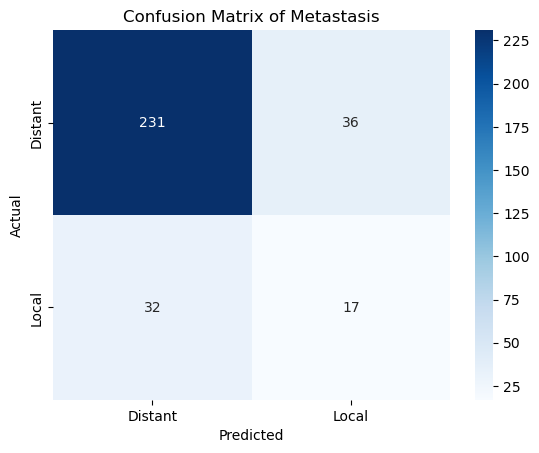

In [94]:
# Assuming y_test and y_pred are your true labels and predicted labels, respectively
conf_matrix = confusion_matrix(y_val_Mets, y_pred_val_Mets)

# Display the confusion matrix as a heatmap
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Distant', 'Local'], yticklabels=['Distant', 'Local'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix of Metastasis')
plt.show()

**KNN Validation**

In [95]:
# Make predictions on the validation set
y_val_pred = best_knn.predict(X_val_Mets)
val_accuracy = accuracy_score(y_val_Mets, y_val_pred)
val_report = classification_report(y_val_Mets, y_val_pred)

print("Validation Set Accuracy:", val_accuracy)
print("Validation Set Classification Report:\n", val_report)

c:\Users\nadat\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


Validation Set Accuracy: 0.7816455696202531
Validation Set Classification Report:
               precision    recall  f1-score   support

           0       0.88      0.86      0.87       267
           1       0.31      0.35      0.33        49

    accuracy                           0.78       316
   macro avg       0.60      0.60      0.60       316
weighted avg       0.79      0.78      0.79       316



**Combined ROC**

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


c:\Users\nadat\anaconda3\Lib\site-packages\sklearn\base.py:457: UserWarning: X has feature names, but KNeighborsClassifier was fitted without feature names
  warnings.warn(


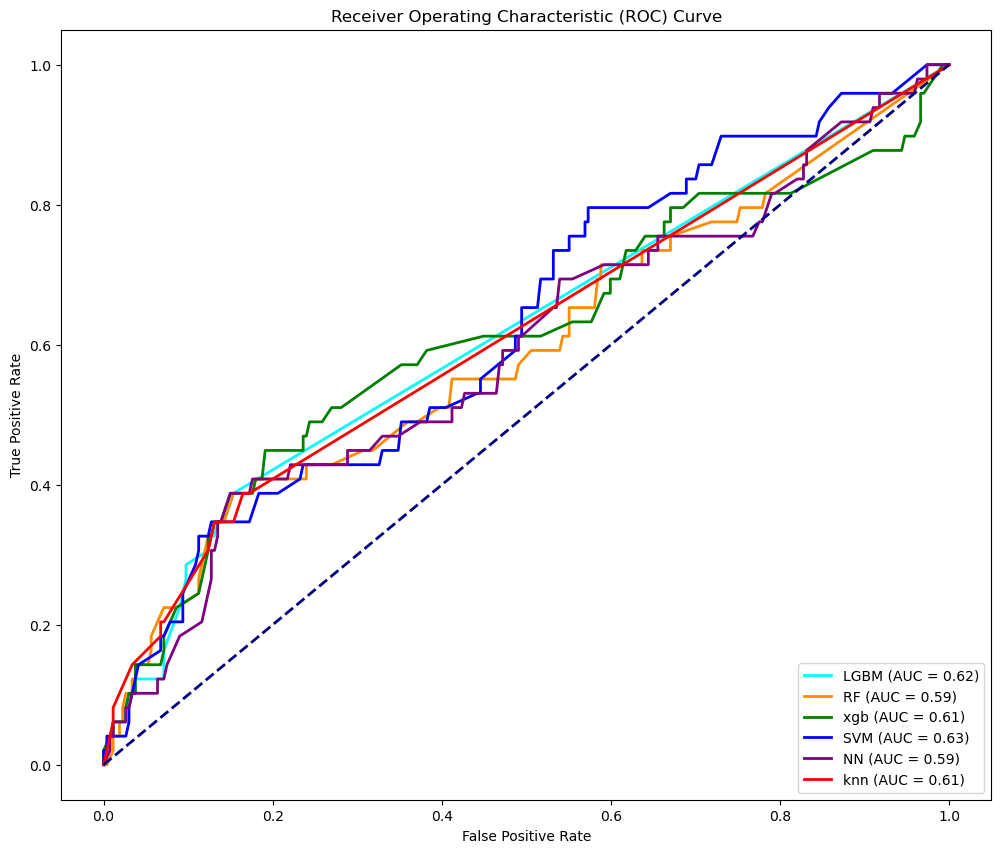

In [96]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Plot ROC curve for clf
y_val_pred_proba_clf = best_rf.predict_proba(X_val_Mets)[:, 1]
fpr_clf, tpr_clf, thresholds_clf = roc_curve(y_val_Mets, y_val_pred_proba_clf)
roc_auc_clf = auc(fpr_clf, tpr_clf)


# Plot ROC curve for xgb
y_val_pred_proba_xgb = best_XG.predict_proba(X_val_Mets)[:, 1]
fpr_xgb, tpr_xgb, thresholds_xgb = roc_curve(y_val_Mets, y_val_pred_proba_xgb)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)


# Plot ROC curve for SVM
y_val_pred_proba_svm = SVM.predict_proba(X_val_Mets)[:, 1] if hasattr(SVM, 'predict_proba') else SVM.decision_function(X_val_Mets)
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_val_Mets, y_val_pred_proba_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)

# Predict probabilities on the validation set
y_val_pred_proba_lgb = best_lgb.predict_proba(X_val_Mets)[:, 1]
fpr_lgb, tpr_lgb, thresholds_lgb = roc_curve(y_val_Mets, y_val_pred_proba_lgb)
roc_auc_lgb = auc(fpr_lgb, tpr_lgb)

# Plot ROC curve for model
y_val_pred_proba_model = model_Mets_NN.predict(X_val_Mets)[:, 0]
fpr_model, tpr_model, thresholds_model = roc_curve(y_val_Mets, y_val_pred_proba_model)
roc_auc_model = auc(fpr_model, tpr_model)

# Plot ROC curve for knn
y_val_pred_proba_knn = best_knn.predict_proba(X_val_Mets)[:, 1]
fpr_knn, tpr_knn, thresholds_knn = roc_curve(y_val, y_val_pred_proba_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)


plt.figure(figsize=(12, 10))

plt.plot(fpr_lgb, tpr_lgb, color='cyan', lw=2, label='LGBM (AUC = {:.2f})'.format(roc_auc_lgb))
plt.plot(fpr_clf, tpr_clf, color='darkorange', lw=2, label='RF (AUC = {:.2f})'.format(roc_auc_clf))
plt.plot(fpr_xgb, tpr_xgb, color='green', lw=2, label='xgb (AUC = {:.2f})'.format(roc_auc_xgb))
plt.plot(fpr_svm, tpr_svm, color='blue', lw=2, label='SVM (AUC = {:.2f})'.format(roc_auc_svm))
plt.plot(fpr_model, tpr_model, color='purple', lw=2, label='NN (AUC = {:.2f})'.format(roc_auc_model))
plt.plot(fpr_knn, tpr_knn, color='red', lw=2, label='knn (AUC = {:.2f})'.format(roc_auc_knn))


plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.savefig('ROC_Combined_LocDist.svg', format='svg')
plt.show()

**Combined evaluation metrics**

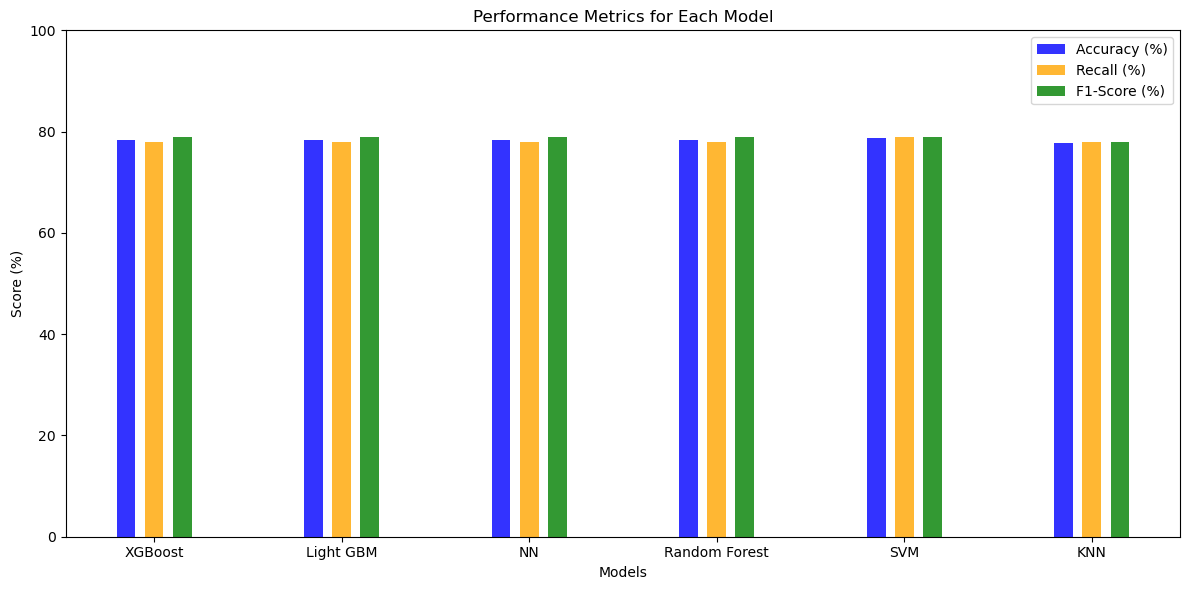

In [97]:
import numpy as np
import matplotlib.pyplot as plt

# Data
models = ['XGBoost', 'Light GBM', 'NN', 'Random Forest', 'SVM', 'KNN']
metrics = ['Accuracy (%)', 'Recall (%)', 'F1-Score (%)']
values = np.array([
    [78.4, 78.4, 78.4, 78.4, 78.7, 77.8],
    [78, 78, 78, 78, 79, 78],
    [79, 79, 79, 79, 79, 78]
])

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

bar_width = 0.1  # thinner bars
opacity = 0.8
space = 0.05  # space between the bars
colors = ['blue', 'orange', 'green']  # Blue, orange, green

for i, metric in enumerate(metrics):
    rects = ax.bar(np.arange(len(models)) + (i * (bar_width + space)), values[i], bar_width,
                   alpha=opacity, color=colors[i], label=metric)

ax.set_xlabel('Models')
ax.set_ylabel('Score (%)')
ax.set_title('Performance Metrics for Each Model')
ax.set_xticks(np.arange(len(models)) + ((len(metrics) - 1) * (bar_width + space)) / 2)  # Center x-ticks
ax.set_xticklabels(models)
ax.set_ylim(0, 100)  # Set y-axis range from 0 to 100
ax.legend()

plt.tight_layout()
plt.savefig('Evaluation_Metrics_all_LocDist.svg', format='svg')
plt.show()


**Combined Confusion matrix**

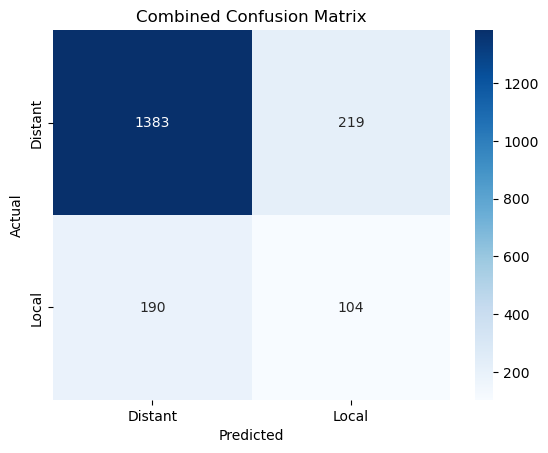

In [98]:
# Confusion matrices for each model
conf_matrix_rf = np.array([[231, 36],
                            [32, 17]])

conf_matrix_xgboost = np.array([[231, 36],
                                 [32, 17]])

conf_matrix_svm = np.array([[232, 35],
                             [32, 17]])

conf_matrix_knn = np.array([[231, 36],
                             [32, 17]])

conf_matrix_nn = np.array([[227, 40],
                            [30, 19]])

conf_matrix_lgbm = np.array([[231, 36],
                            [32, 17]])


# Sum up corresponding cells
combined_conf_matrix = conf_matrix_rf + conf_matrix_xgboost + conf_matrix_svm + conf_matrix_knn + conf_matrix_nn + conf_matrix_lgbm

import seaborn as sns
import matplotlib.pyplot as plt


# Plotting
class_labels = ['Distant', 'Local']
sns.heatmap(combined_conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Combined Confusion Matrix')
plt.savefig('Combined CM_LocDist.svg', format='svg')
plt.show()

___________________________________________________________________________________________________________________________________________________________

# **Make comparison between local & distant types in baheya and our data**

In [99]:
# merged data
local_df = balanced_data[balanced_data['Recurrence_Type'] == 'Local']
distant_df = balanced_data[balanced_data['Recurrence_Type'] == 'Distant']

specified_sample_size = 49  

sample_size = min(specified_sample_size, len(local_df), len(distant_df))

local_sample = local_df.sample(n=sample_size, random_state=1) 
distant_sample = distant_df.sample(n=sample_size, random_state=1)

sampled_df = pd.concat([local_sample, distant_sample])

sampled_df = sampled_df.sample(frac=1, random_state=1).reset_index(drop=True)

In [100]:
# Baheya data
local_df_b = Baheya_data[Baheya_data['Recurrence_Type'] == 'Local']
distant_df_b = Baheya_data[Baheya_data['Recurrence_Type'] == 'Distant']


specified_sample_size = 49  

sample_size_b = min(specified_sample_size, len(local_df), len(distant_df))

local_sample_b = local_df_b.sample(n=sample_size_b, random_state=1)  
distant_sample_b = distant_df_b.sample(n=sample_size_b, random_state=1)

sampled_df_b = pd.concat([local_sample_b, distant_sample_b])

sampled_df_b = sampled_df_b.sample(frac=1, random_state=1).reset_index(drop=True)

In [101]:
sampled_df_b['Recurrence_Type'].value_counts()

Recurrence_Type
Distant    49
Local      49
Name: count, dtype: int64

In [104]:
sampled_df.columns

Index(['Tumor Size', 'Recurrence_Type', 'Lymph Node Status', 'Tumor Grade',
       'Mol Subtype', 'Histological Type', 'ER', 'PR', 'HER2',
       'Tumor Location'],
      dtype='object')

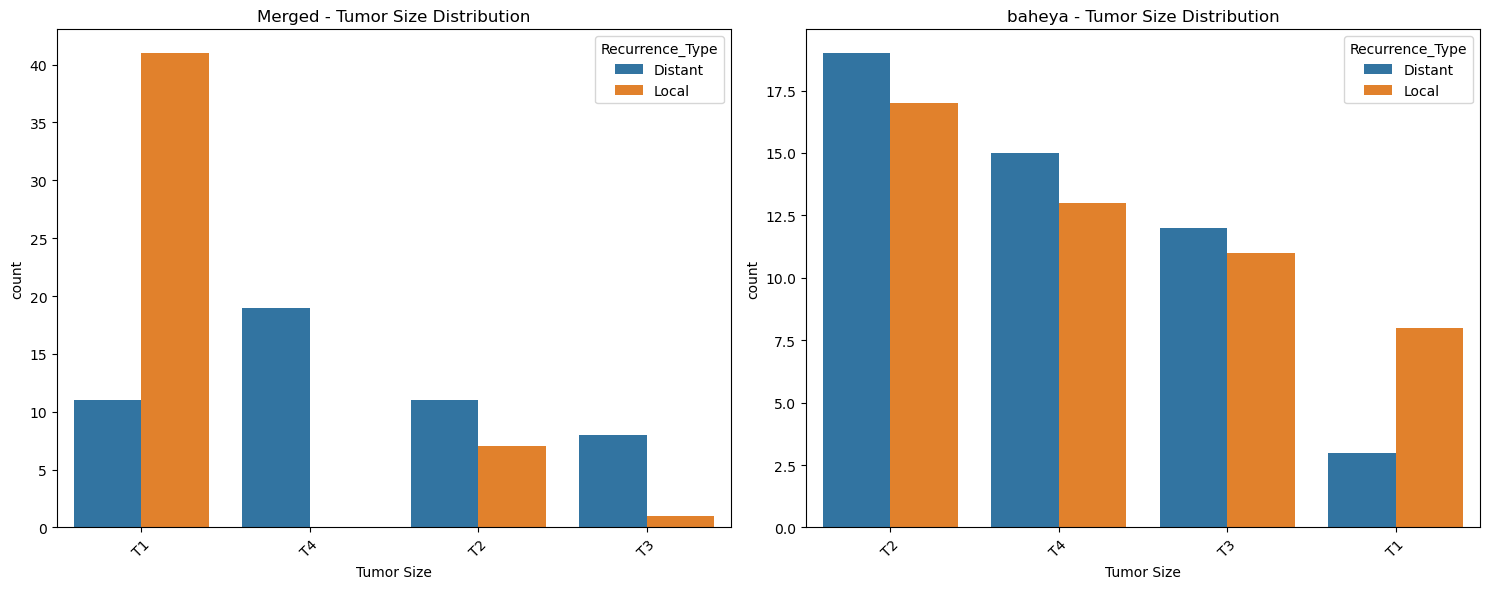

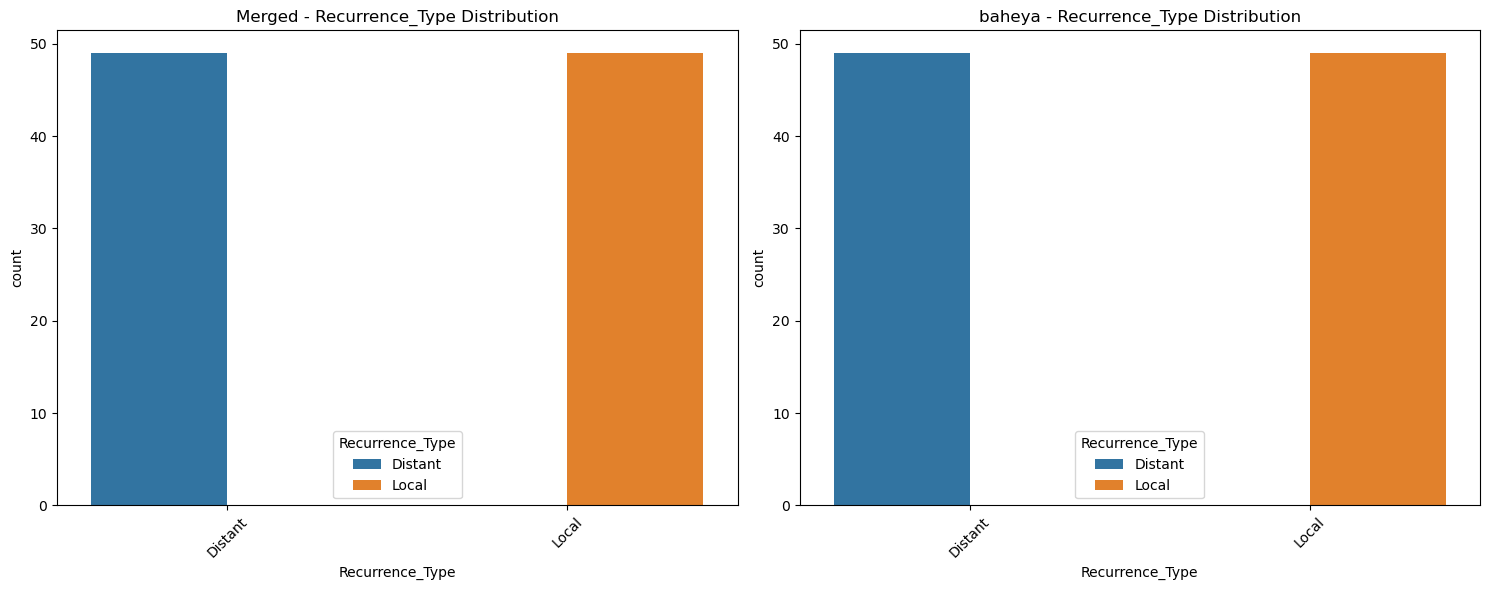

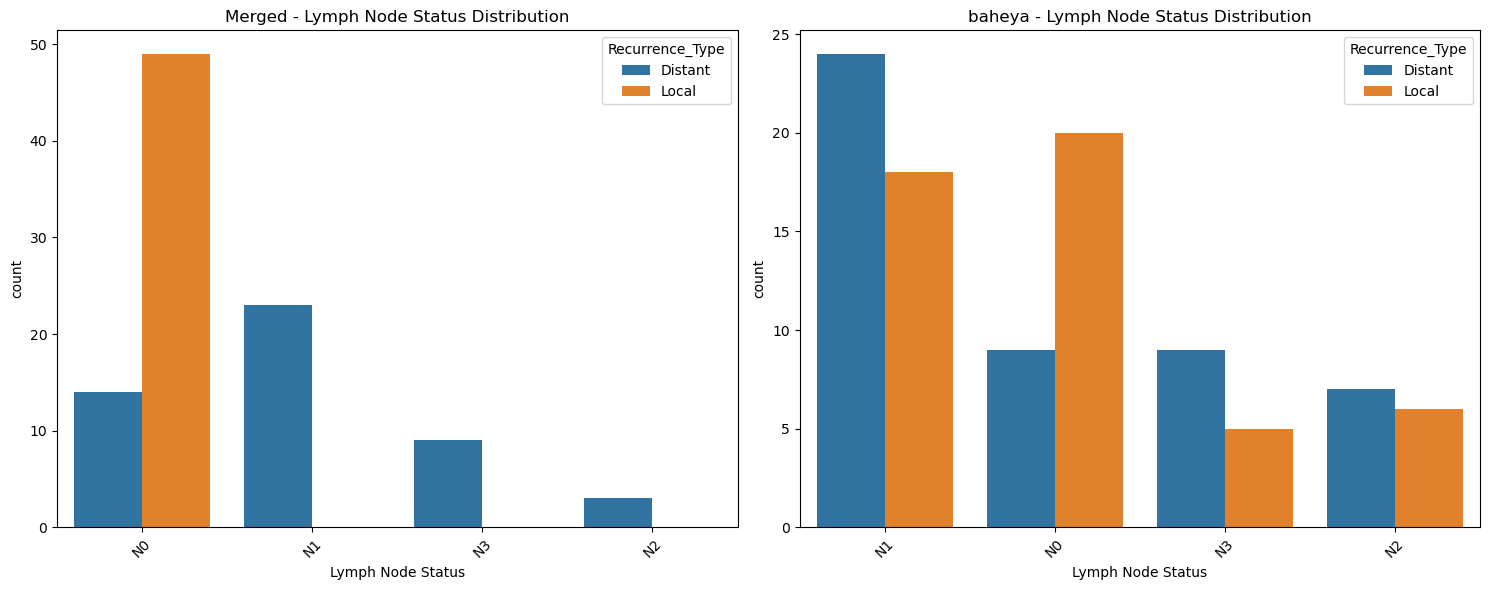

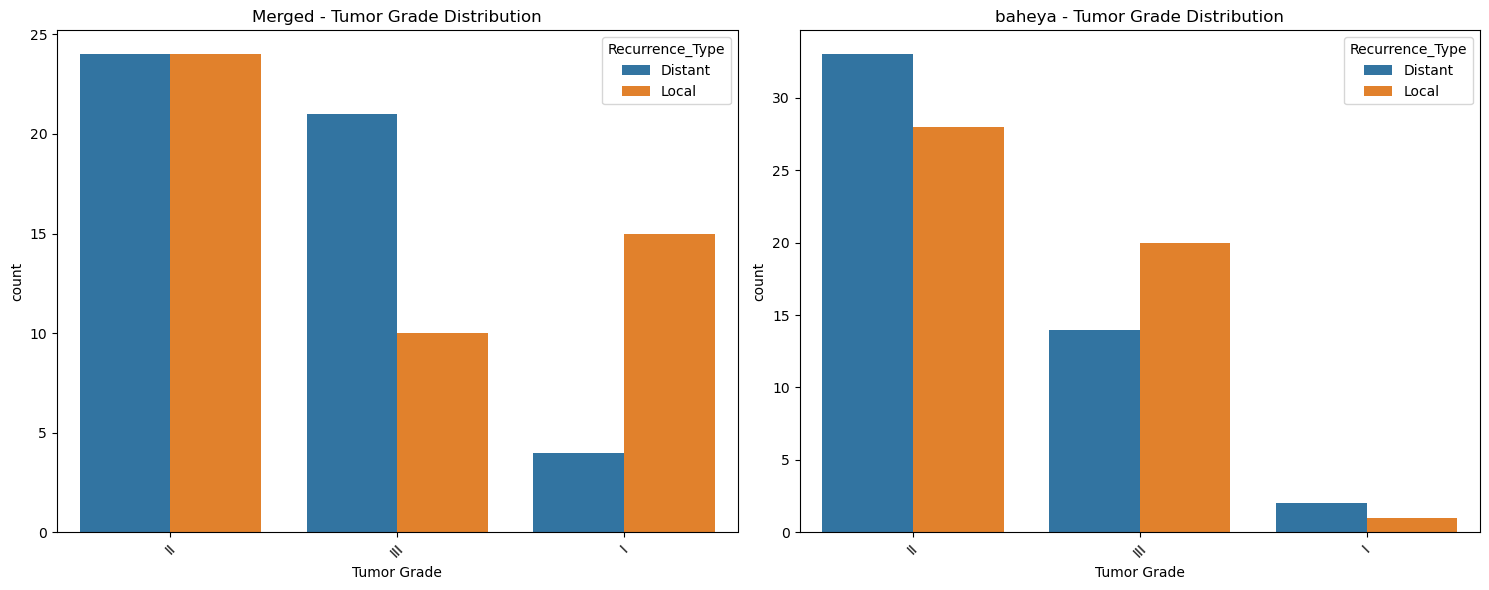

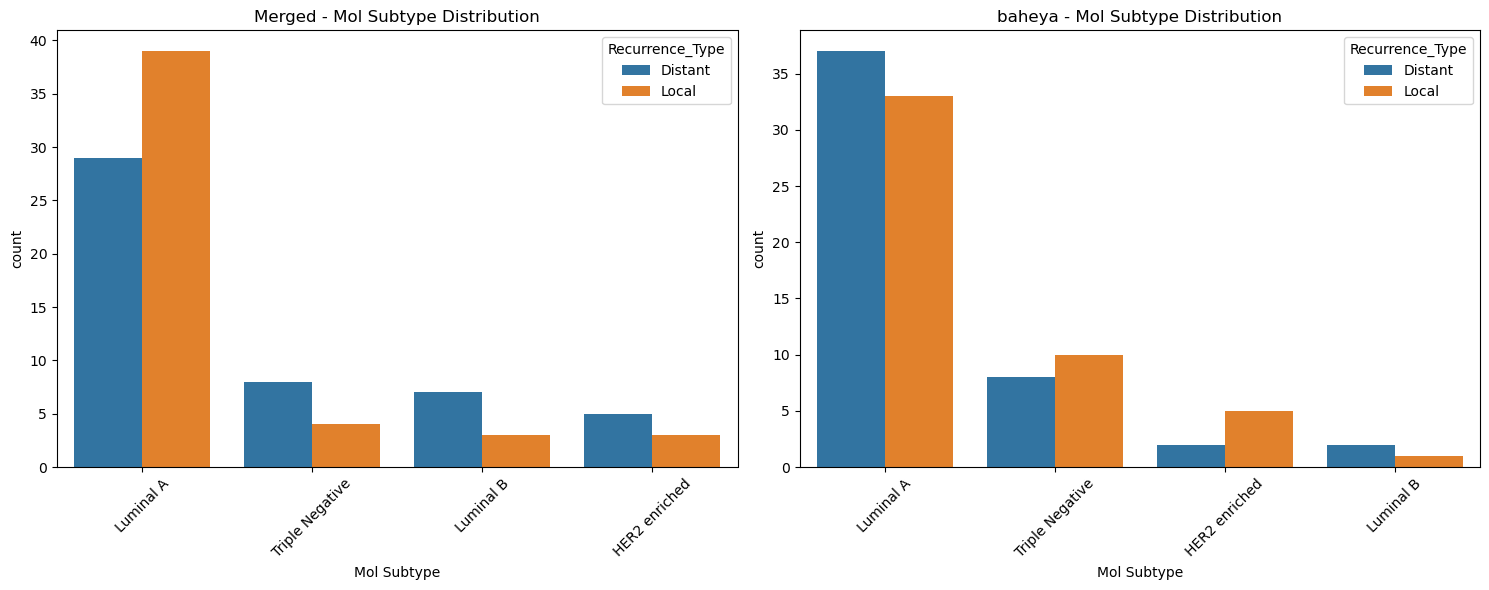

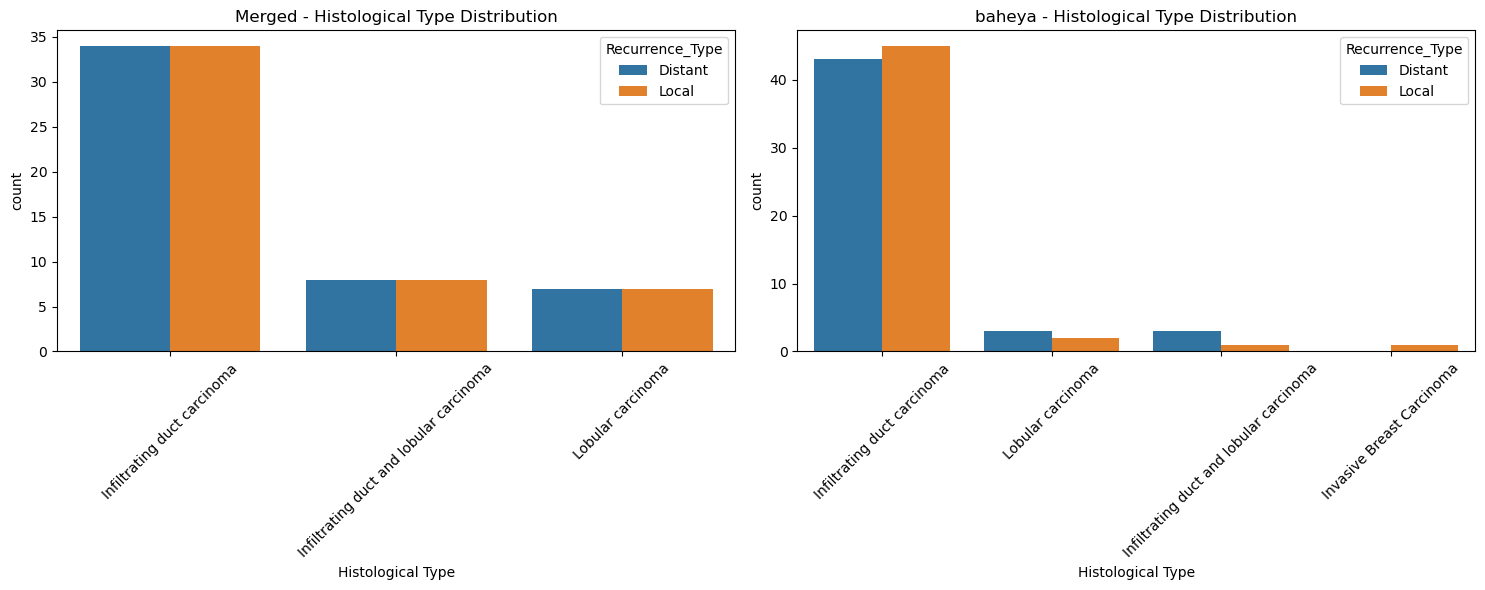

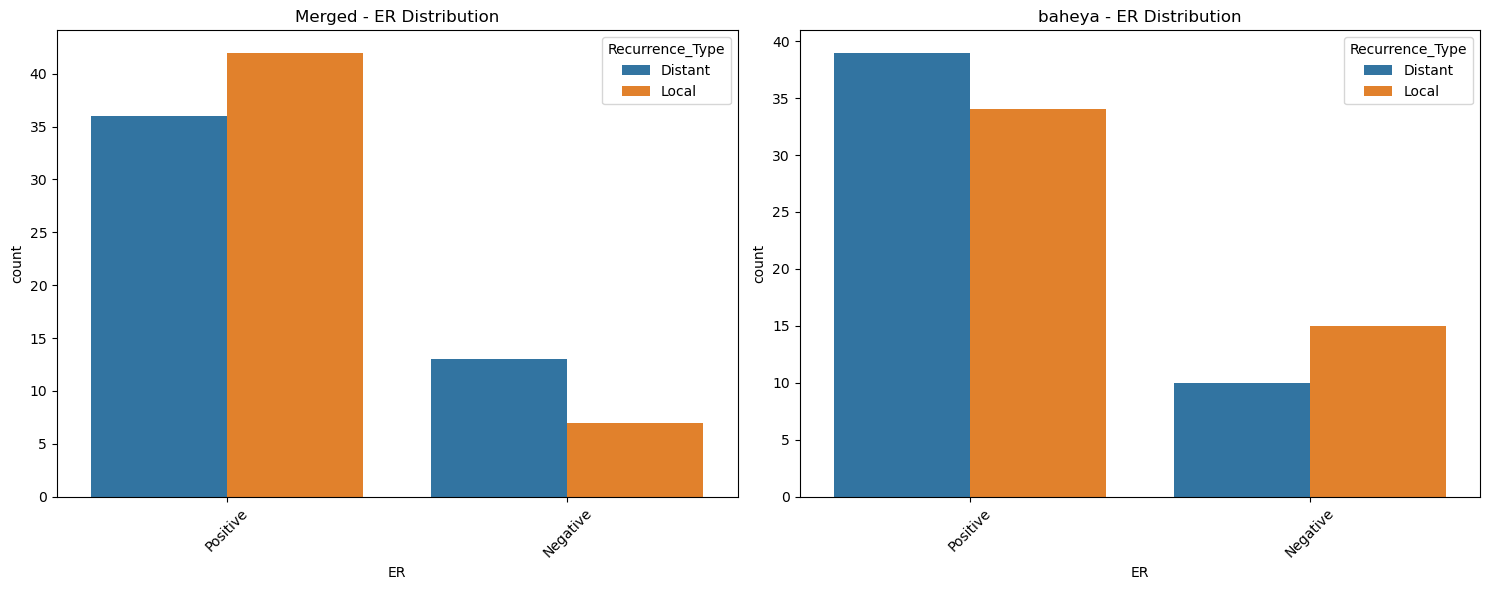

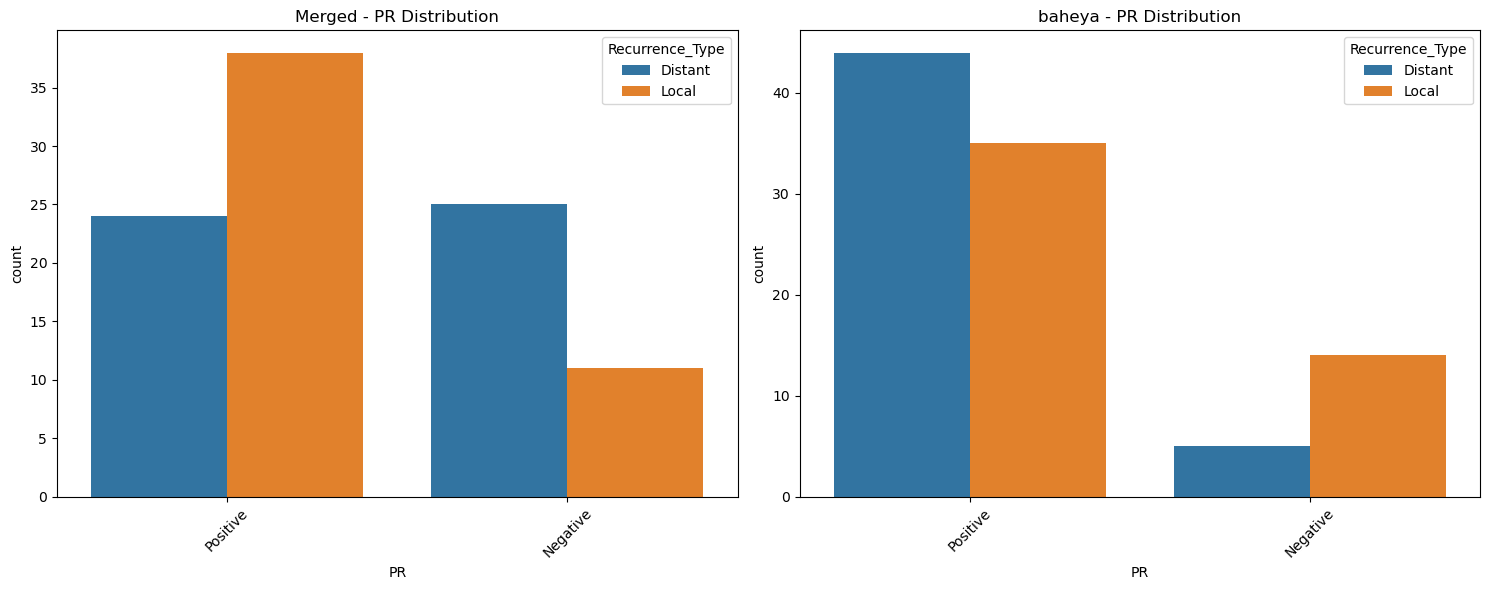

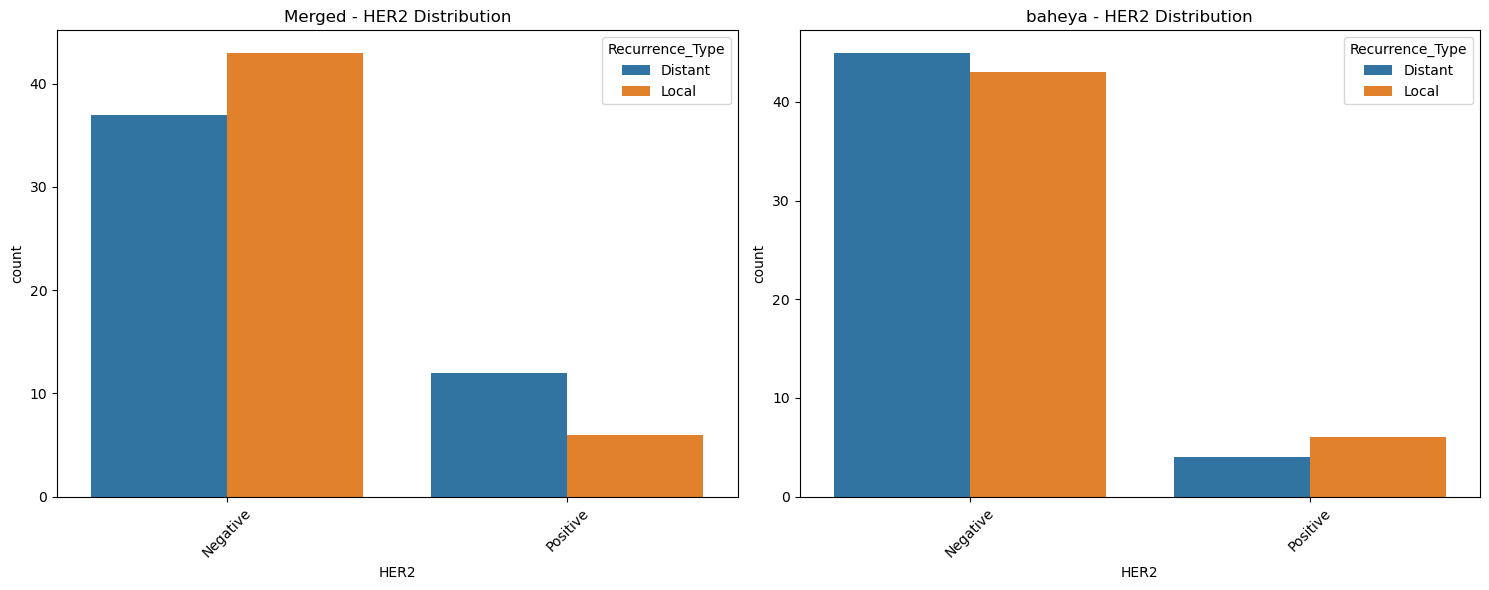

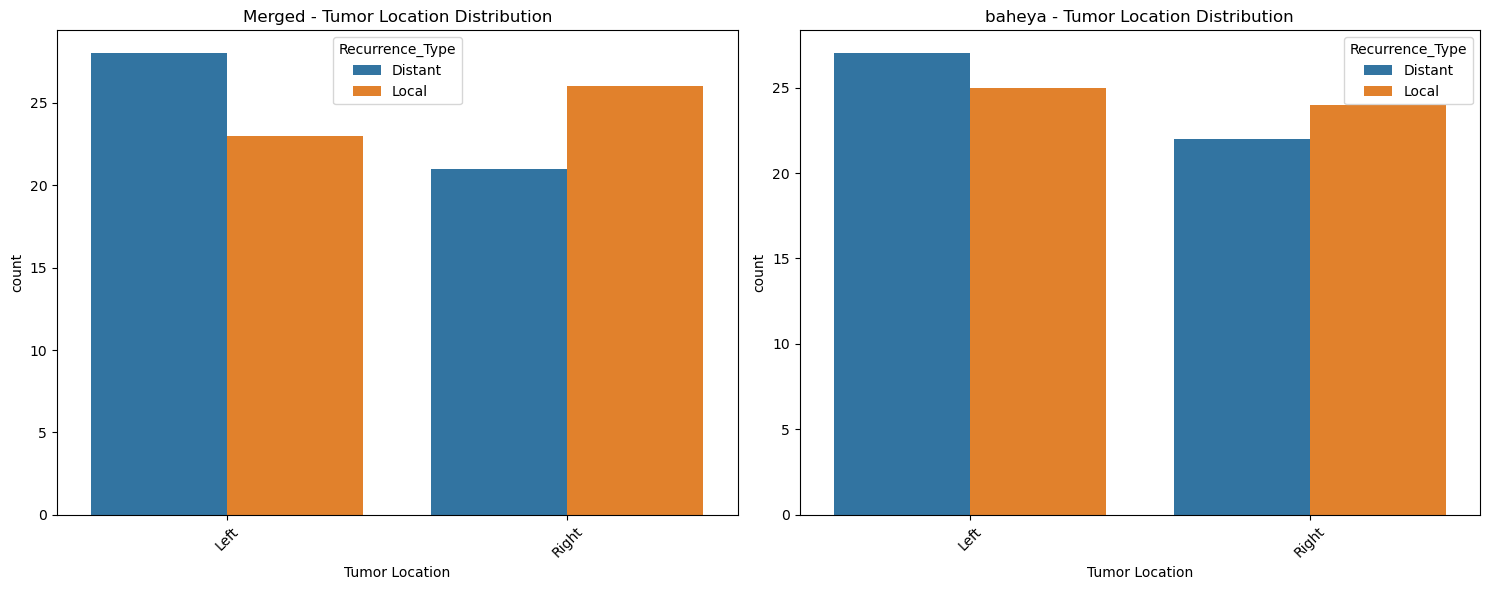

In [103]:
import seaborn as sns
import matplotlib.pyplot as plt

for column in sampled_df.columns:
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))  # Create subplots with 1 row and 2 columns

    # Plot for the merged dataset
    sns.countplot(data=sampled_df, x=column, order=sampled_df[column].value_counts().index, hue='Recurrence_Type', ax=axes[0])
    axes[0].set_title(f'Merged - {column} Distribution')
    axes[0].tick_params(axis='x', rotation=45)

    # Plot for the baheya dataset
    sns.countplot(data=sampled_df_b, x=column, order=sampled_df_b[column].value_counts().index, hue='Recurrence_Type', ax=axes[1])
    axes[1].set_title(f'baheya - {column} Distribution')
    axes[1].tick_params(axis='x', rotation=45)

    plt.tight_layout()

    # Save the figure as an SVG file with the feature name in the filename
    filename = f'{column}_distribution.svg'
    plt.savefig(filename, format='svg')

    plt.show()
